In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arma_tools import AR, ACF, PACF
from metrics import ARMAEstimation

plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=6, suppress = True)
pd.options.display.float_format = '{:.6f}'.format

### Завантаження даних

In [2]:
data = pd.read_csv('./lab5_data/ARCH_01.dat', squeeze=True, header=None, names=['ARCH'])

Mean: 0.263369
Std: 4.894091


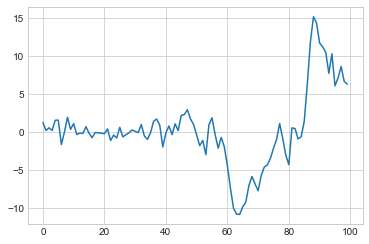

In [3]:
print(f'Mean: {data.mean():.6f}\nStd: {data.std():.6f}')
data.plot();

### АР(1), АКФ та ЧАКФ для залишків цієї моделі та їх квадратів

In [4]:
ar1 = AR(data, p=1)
resid = ar1['residuals']
resid2 = resid**2

In [5]:
ARMAEstimation(ar1['actual'].values, ar1['fitted'].values, ar1['model_order'])

R-squared                  0.877424
Adjusted R-squared         0.874871
S.E. of regression         1.713089
Sum squared resid        290.532836
Log likelihood          -144.266454
Durbin-Watson stat         1.697522
Mean dependent var         0.253171
S.D. dependent var         4.583345
Akaike info criterion      2.954878
Schwarz criterion          3.007305
dtype: float64

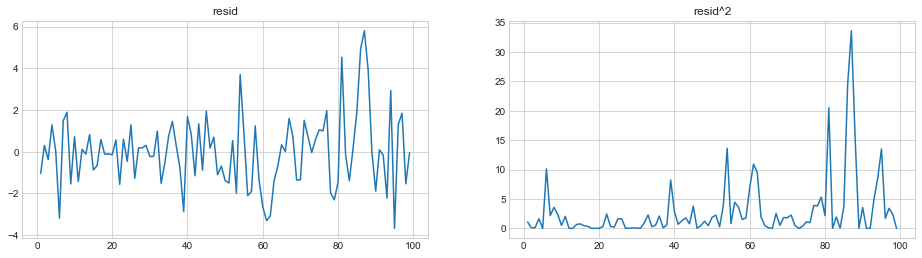

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(resid)
ax[0].set_title('resid')
ax[1].plot(resid2)
ax[1].set_title('resid^2')
plt.show()

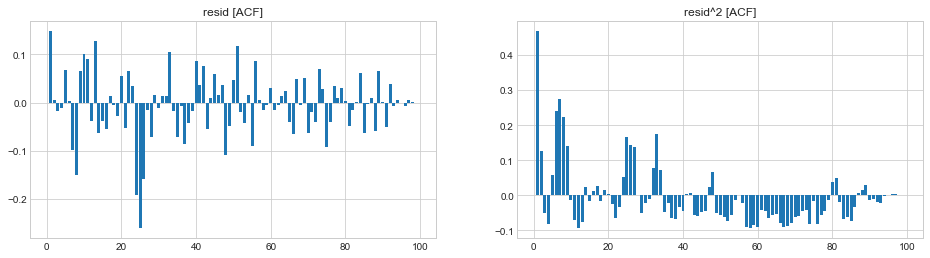

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].bar(np.arange(resid.index.start, resid.index.stop), ACF(resid))
ax[0].set_title('resid [ACF]')
ax[1].bar(np.arange(resid2.index.start, resid2.index.stop), ACF(resid2))
ax[1].set_title('resid^2 [ACF]')
plt.show()

### АРУГ(1) та АРУГ(4)

In [8]:
arch_1 = AR(resid2, p=1)
arch_4 = AR(resid2, p=4)

R-squared                  0.221067
Adjusted R-squared         0.204668
S.E. of regression         4.637963
Sum squared resid       2108.048629
Log likelihood          -240.414951
Durbin-Watson stat         1.884876
Mean dependent var         2.953528
S.D. dependent var         2.470809
Akaike info criterion      4.947244
Schwarz criterion          4.999998
dtype: float64


e^2(k) = 1.5583 + 0.4706*e^2(k-1) 


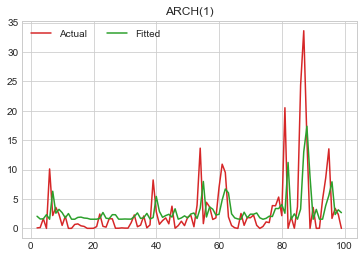

In [9]:
plt.plot(arch_1['actual'], label='Actual', color='tab:red')
plt.plot(arch_1['fitted'], label='Fitted', color='tab:green')
plt.legend(loc='upper left', ncol=2)
plt.title(f'ARCH(1)')

print(ARMAEstimation(arch_1['actual'].values, arch_1['fitted'].values, arch_1['model_order']))
print('\n')

p = arch_1['model_order'][0]
coef = arch_1['coefficients']
eq = f'e^2(k) = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*e^2(k-{k}) ' if coef[k]>=0 else f'- {-coef[k]:.4f}*e^2(k-{k}) '
print(eq)

R-squared                  0.234413
Adjusted R-squared         0.191402
S.E. of regression         4.654279
Sum squared resid       2057.919450
Log likelihood          -233.388920
Durbin-Watson stat         1.990939
Mean dependent var         3.026931
S.D. dependent var         2.575406
Akaike info criterion      5.018714
Schwarz criterion          5.153129
dtype: float64


e^2(k) = 1.9548 + 0.5136*e^2(k-1) - 0.0790*e^2(k-2) - 0.0751*e^2(k-3) - 0.0096*e^2(k-4) 


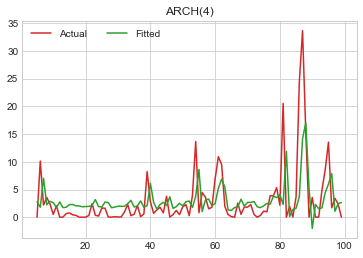

In [10]:
plt.plot(arch_4['actual'], label='Actual', color='tab:red')
plt.plot(arch_4['fitted'], label='Fitted', color='tab:green')
plt.legend(loc='upper left', ncol=2)
plt.title(f'ARCH(4)')

print(ARMAEstimation(arch_4['actual'].values, arch_4['fitted'].values, arch_4['model_order']))
print('\n')

p = arch_4['model_order'][0]
coef = arch_4['coefficients']
eq = f'e^2(k) = {coef[0]:.4f} '
for k in range(1, p+1):
    eq += f'+ {coef[k]:.4f}*e^2(k-{k}) ' if coef[k]>=0 else f'- {-coef[k]:.4f}*e^2(k-{k}) '
print(eq)

### УАРУГ модель

In [11]:
def CondMean(y):
    start_ind, stop_ind = y.index.start, y.index.stop
    res = []
    for k in range(start_ind+1, stop_ind):
        res.append(y[:k+1].mean())
    return pd.Series(res, index=pd.RangeIndex(start_ind+1, stop_ind))

def CondVar(y):
    start_ind, stop_ind = y.index.start, y.index.stop
    res = []
    for k in range(start_ind+1, stop_ind):
        res.append(y[:k+1].var())
    return pd.Series(res, index=pd.RangeIndex(start_ind+1, stop_ind))


In [12]:
def GARCH(eps2, h, pacf_tolerance=None):
    if pacf_tolerance is None:
        pacf_tolerance = 1.96 / np.sqrt(len(h))
    try:
        q = np.where(abs(PACF(eps2, maxlag=12)) >= pacf_tolerance)[0].max()+1
    except ValueError:
        q = 0
    try:
        p = np.where(abs(PACF(h, maxlag=12)) >= pacf_tolerance)[0].max()+1
    except ValueError:
        p = 0
    n = len(h)
    column_names = ['const']
    for k in range(1, q+1):
        column_names.append(f'e^2(k-{k})')
    for k in range(1, p+1):
        column_names.append(f'h(k-{k})')
    Y = pd.DataFrame(columns=column_names)
    for k in range(1, q+1):
        Y.loc[:, f'e^2(k-{k})'] = eps2.shift(k)
    for k in range(1, p+1):
        Y.loc[:, f'h(k-{k})'] = h.shift(k)
    Y['const'] = 1
    Y_np = Y.dropna().to_numpy()
    actual = h.iloc[-len(Y_np):]
    coefs = (np.linalg.pinv(Y_np.T @ Y_np) @ Y_np.T) @ actual
    fitted = Y.dropna() @ coefs
    return {'actual': actual,
            'fitted': fitted,
            'Y': Y,
            'coefficients': coefs,
            'residuals': actual - fitted,
            'model_order': (p, q),
            'column_names': Y.columns}

УАРУГ модель для h(k) з умовних дисперсій вхідних даних

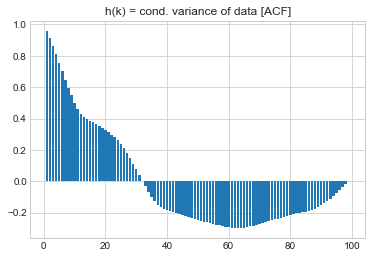

In [13]:
h = CondVar(data)
plt.bar(np.arange(h.index.start, h.index.stop), ACF(h))
plt.title('h(k) = cond. variance of data [ACF]')
plt.show()

R-squared                0.996164
Adjusted R-squared       0.996041
S.E. of regression       0.438762
Sum squared resid       18.866145
Log likelihood          -9.323654
Durbin-Watson stat       0.648741
Mean dependent var       5.771766
S.D. dependent var       7.070357
Akaike info criterion    0.251503
Schwarz criterion        0.330635
dtype: float64


h(k) = -0.0306 + 0.0541*e^2(k-1) + 1.0197*h(k-1) 


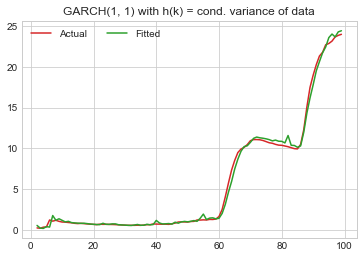

In [14]:
garch_data = GARCH(resid2, CondVar(data), pacf_tolerance=None)

plt.plot(garch_data['actual'], label='Actual', color='tab:red')
plt.plot(garch_data['fitted'], label='Fitted', color='tab:green')
plt.legend(loc='upper left', ncol=2)
plt.title(f'GARCH{garch_data["model_order"]} with h(k) = cond. variance of data')

print(ARMAEstimation(garch_data['actual'].values, garch_data['fitted'].values, garch_data['model_order']))
print('\n')

p, q = garch_data['model_order']
coef = garch_data['coefficients']
eq = f'h(k) = {coef[0]:.4f} '
for k in range(1, q+1):
    eq += f'+ {coef[k]:.4f}*e^2(k-{k}) ' if coef[k]>=0 else f'- {-coef[k]:.4f}*e^2(k-{k}) '
for k in range(1, p+1):
    eq += f'+ {coef[p+k]:.4f}*h(k-{k}) ' if coef[q+k]>=0 else f'- {-coef[q+k]:.4f}*h(k-{q+k}) '
print(eq)

УАРУГ модель для h(k) з умовних дисперсій залишків моделі АР(1)

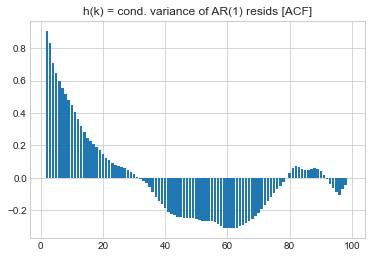

In [15]:
h = CondVar(resid)
plt.bar(np.arange(h.index.start, h.index.stop), ACF(h))
plt.title('h(k) = cond. variance of AR(1) resids [ACF]')
plt.show()

R-squared                 0.985418
Adjusted R-squared        0.983438
S.E. of regression        0.070884
Sum squared resid         0.467288
Log likelihood          160.682213
Durbin-Watson stat        2.102513
Mean dependent var        1.814594
S.D. dependent var        0.582710
Akaike info criterion    -3.218972
Schwarz criterion        -2.919418
dtype: float64


h(k) = 0.0395 - 0.0020*e^2(k-1) + 0.0022*e^2(k-2) - 0.0014*e^2(k-3) + 0.0020*e^2(k-4) + 0.0020*e^2(k-5) + 0.0017*e^2(k-6) + 1.4714*h(k-1) - 0.4050*h(k-2) - 0.1705*h(k-3) + 0.0755*h(k-4) 


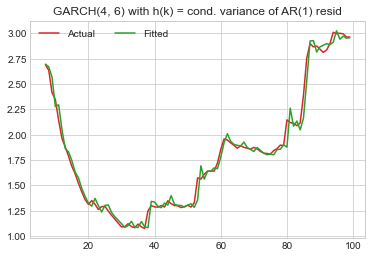

In [16]:
garch_resid = GARCH(resid2, CondVar(resid), pacf_tolerance=0.15)

plt.plot(garch_resid['actual'], label='Actual', color='tab:red')
plt.plot(garch_resid['fitted'], label='Fitted', color='tab:green')
plt.legend(loc='upper left', ncol=2)
plt.title(f'GARCH{garch_resid["model_order"]} with h(k) = cond. variance of AR(1) resid')

print(ARMAEstimation(garch_resid['actual'].values, garch_resid['fitted'].values, garch_resid['model_order']))
print('\n')

p, q = garch_resid['model_order']
coef = garch_resid['coefficients']
eq = f'h(k) = {coef[0]:.4f} '
for k in range(1, q+1):
    eq += f'+ {coef[k]:.4f}*e^2(k-{k}) ' if coef[k]>=0 else f'- {-coef[k]:.4f}*e^2(k-{k}) '
for k in range(1, p+1):
    eq += f'+ {coef[q+k]:.4f}*h(k-{k}) ' if coef[q+k]>=0 else f'- {-coef[q+k]:.4f}*h(k-{k}) '
print(eq)